**<h1>Setup and data processing<h1>**

---



<h3>Package installation<h3>


In [25]:
%pip install sys
%pip install pandas
%pip install python-binance
%pip install ta
%pip install matplotlib
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement sys (from versions: none)
ERROR: No matching distribution found for sys
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


<h3>Imports<h3>

In [26]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta
from binance.client import Client

**<h1>Inputs<h1>**

---



<h3>Asset<h3>

In [27]:
name_base = "BTC"
name_quote = "USDT"

<h3>Data<h3>

In [28]:
timeframe = "1d"
starting_date_backtest = "01 january 2019"
ending_date_backtest =  "01 january 2022"
starting_date_dl = "01 january 2018"
ending_date_dl = "01 january 2022"

<h3>Portfolio<h3>

In [29]:
initial_capital = 1000 # in quote
exposure = 2           # in percent
# exposure = 'all'       # use this instead if you want 100% of your portfolio to be used for each trade
trade_fees = 0.1       # in percent
leverage = 5

<h3>Ignores<h3>

In [30]:
ignore_shorts = False
ignore_longs = False

ignore_tp = False
ignore_sl = False
ignore_exit = False

**<h1>
Download Data<h1>**

---

In [31]:
def download_data(name_base, name_quote, timeframe, starting_date, ending_date):
    info = Client().get_historical_klines(name_base+name_quote, timeframe, starting_date, ending_date)
    data = pd.DataFrame(info, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])
    data.drop(columns=data.columns.difference(['timestamp', 'open', 'high', 'low', 'close']), inplace=True)
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    data['open'] = pd.to_numeric(data['open'])
    data['high'] = pd.to_numeric(data['high'])
    data['low'] = pd.to_numeric(data['low'])
    data['close'] = pd.to_numeric(data['close'])
    return data

In [32]:
data_dl = download_data(name_base, name_quote, timeframe, starting_date_dl, ending_date_dl)
data_dl

,timestamp,open,high,low,close
0,2018-01-01,13715.65,13818.55,12750.00,13380.00
1,2018-01-02,13382.16,15473.49,12890.02,14675.11
2,2018-01-03,14690.00,15307.56,14150.00,14919.51
3,2018-01-04,14919.51,15280.00,13918.04,15059.54
4,2018-01-05,15059.56,17176.24,14600.00,16960.39
...,...,...,...,...,...
1457,2021-12-28,50701.44,50704.05,47313.01,47543.74
1458,2021-12-29,47543.74,48139.08,46096.99,46464.66
1459,2021-12-30,46464.66,47900.00,45900.00,47120.87
1460,2021-12-31,47120.88,48548.26,45678.00,46216.93


**<h1>Strategy<h1>**

---

In [33]:
def compute_indicators(data): # check https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html
    data['EMAf'] = ta.trend.ema_indicator(data['close'], 10)
    data['EMAs'] = ta.trend.ema_indicator(data['close'], 30)
    data['Trend'] = ta.trend.sma_indicator(data['close'], 50)
    data['RSI'] = ta.momentum.rsi(data['close'])
    data['ATR'] = ta.volatility.average_true_range(data['high'], data['low'], data['close'], window=14)

    # MACD = ta.trend.MACD(data['close'], window_slow=26, window_fast=12, window_sign=9)
    # data['MACD'] = MACD.macd()
    # data['MACD_histo'] = MACD.macd_diff()
    # data['MACD_signal'] = MACD.macd_signal()

    # BB = ta.volatility.BollingerBands(close=data['close'], window=100, window_dev=2)
    # data["BB_lower"] = BB.bollinger_lband()
    # data["BB_upper"] = BB.bollinger_hband()
    # data["BB_avg"] = BB.bollinger_mavg()

    return data

In [34]:
def prepare_data(data, starting_date, ending_date):
    data2 = data.copy()
    data2 = compute_indicators(data2)
    data2 = data2[(data2['timestamp'] > starting_date + ' 00:00:00') & (data2['timestamp'] < ending_date + ' 00:00:00')]
    data2.dropna(inplace=True)
    return data2

In [35]:
data = prepare_data(data_dl, starting_date_backtest, ending_date_backtest)
data

,timestamp,open,high,low,close,EMAf,EMAs,Trend,RSI,ATR
366,2019-01-02,3796.45,3882.14,3750.45,3858.56,3775.198535,3874.169040,4026.7196,50.645194,249.676827
367,2019-01-03,3857.57,3862.74,3730.00,3766.78,3773.667892,3867.240715,3983.6070,48.072505,241.324196
368,2019-01-04,3767.20,3823.64,3703.57,3792.01,3777.002821,3862.387120,3944.3792,48.841844,232.663182
369,2019-01-05,3790.09,3840.99,3751.00,3770.96,3775.904126,3856.488596,3906.6796,48.200208,222.472241
370,2019-01-06,3771.12,4027.71,3740.00,3987.60,3814.394285,3864.947397,3873.8658,54.783790,227.132081
...,...,...,...,...,...,...,...,...,...,...
1456,2021-12-27,50775.48,52088.00,50449.00,50701.44,49736.414486,50936.724253,54526.7194,50.241134,2469.152594
1457,2021-12-28,50701.44,50704.05,47313.01,47543.74,49337.746398,50717.822043,54127.0776,40.655289,2535.001694
1458,2021-12-29,47543.74,48139.08,46096.99,46464.66,48815.367053,50443.424492,53717.4176,37.987915,2499.793716
1459,2021-12-30,46464.66,47900.00,45900.00,47120.87,48507.276679,50229.066137,53362.1864,40.542652,2464.094165


<h3>Longs<h3>

In [36]:
def check_long_entry_condition(row, previous_row):
    return row['close'] > row['Trend'] and row['EMAf'] > row['EMAs'] and previous_row['EMAf'] < previous_row['EMAs'] and row['RSI'] < 70


def check_long_exit_condition(row, previous_row):
    return row['EMAf'] < row['EMAs'] and previous_row['EMAf'] > previous_row['EMAs']


def compute_long_sl_level(row, entry_price):
    return entry_price - 2 * row['ATR']


def compute_long_tp_level(row, entry_price, stop_loss_price):
    risk_reward_ratio = 4
    return entry_price * (1 + risk_reward_ratio * (1 - stop_loss_price / entry_price))
    # return row['open'] * 1.1

<h3>Shorts<h3>

In [37]:
def check_short_entry_condition(row, previous_row):
    return row['close'] < row['Trend'] and row['EMAf'] < row['EMAs'] and previous_row['EMAf'] > previous_row['EMAs'] and row['RSI'] > 30


def check_short_exit_condition(row, previous_row):
    return row['EMAf'] > row['EMAs'] and previous_row['EMAf'] < previous_row['EMAs']


def compute_short_sl_level(row, entry_price):
    return entry_price + 2 * row['ATR']


def compute_short_tp_level(row, entry_price, stop_loss_price):
    risk_reward_ratio = 4
    return entry_price * (1 - risk_reward_ratio * (stop_loss_price / entry_price - 1))

**<h1>Core Functions<h1>**

---

In [38]:
def calculate_position_size(balance, exposure, entry_price, stop_loss_price):
    if exposure == 'all':
        return balance
    risked_amount = balance * (exposure / 100)
    position = risked_amount * entry_price / abs(entry_price - stop_loss_price)
    return min(balance, position)


def calculate_liquidation_price(price, leverage, order_type):
        if order_type == 'long':
            return price * (1 - 1 / leverage)
        elif order_type == 'short':
            return price * (1 + 1 / leverage)


def calculate_pnl(entry_price, exit_price, quantity, order_type):
    if order_type == 'long':
        return (exit_price - entry_price) * quantity
    elif order_type == 'short':
        return (entry_price - exit_price) * quantity

In [54]:
def record_order(timestamp, type, price, amount, pnl, wallet, fee, orders):
    order = {
        'timestamp': timestamp,
        'type': type,
        'amount': amount,
        'fee': fee,
        'pnl': pnl,
        'wallet': wallet,
    }
    orders.append(order)
    print(f"{type} at {price} {name_quote} on {timestamp}, amount = {round(amount,2)} {name_quote}, pnl = {round(pnl,2)} {name_quote}, wallet = {round(wallet,2)} {name_quote}")

In [55]:
def run_backtest(data):

    # Initialize variables
    orders = []
    order_in_progress = None
    last_ath = 0
    sl_price = 0
    tp_price = 0
    long_liquidation_price = 0
    short_liquidation_price = 1e10
    wallet = initial_capital
    data['realised_pnl'] = ''
    data['unrealised_pnl'] = ''
    data['hodl'] = ''
    data['drawdown'] = ''
    previous_row = data.iloc[0]


    # Go through data and make trades
    for index, row in data.iterrows():
        price = row['close']


        # check if it is time to close a long
        if order_in_progress == 'long' and not ignore_longs:
            if row['low'] < long_liquidation_price:
                print(f' /!\ Your long was liquidated on the {row["timestamp"]} (price = {long_liquidation_price} {name_quote})')
                sys.exit()

            elif not ignore_sl and row['low'] <= sl_price:
                pnl = calculate_pnl(entry_price, price, quantity, order_in_progress)
                fee_exit = quantity * price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'long sl', price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            elif not ignore_tp and row['high'] >= tp_price:
                pnl = calculate_pnl(entry_price, price, quantity, order_in_progress)
                fee_exit = quantity * price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'long tp', price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            elif not ignore_exit and check_long_exit_condition(row, previous_row):
                pnl = calculate_pnl(entry_price, price, quantity, order_in_progress)
                fee_exit = quantity * price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'long exit', price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            if wallet > last_ath:
                last_ath = wallet


        # check if it is time to close a short
        elif order_in_progress == 'short' and not ignore_shorts:
            if row['high'] > short_liquidation_price:
                print(f' /!\ Your short was liquidated on the {row["timestamp"]} (price = {short_liquidation_price} {name_quote})')
                sys.exit()

            elif not ignore_sl and row['high'] >= sl_price:
                pnl = calculate_pnl(entry_price, price, quantity, order_in_progress)
                fee_exit = quantity * price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'short sl', price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            elif not ignore_tp and row['low'] <= tp_price:
                pnl = calculate_pnl(entry_price, price, quantity, order_in_progress)
                fee_exit = quantity * price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'short tp', price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            elif not ignore_exit and check_short_exit_condition(row, previous_row):
                pnl = calculate_pnl(entry_price, price, quantity, order_in_progress)
                fee_exit = quantity * price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'short exit', price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            if wallet > last_ath:
                last_ath = wallet


        # check it is time to enter a long
        if not ignore_longs and order_in_progress == None:
            if check_long_entry_condition(row, previous_row):
                order_in_progress = 'long'
                if not ignore_sl:
                    sl_price = compute_long_sl_level(row, price)
                if not ignore_tp:
                    tp_price = compute_long_tp_level(row, price, sl_price)
                entry_price = price
                position = calculate_position_size(wallet, exposure, price, sl_price)
                amount = position * leverage
                fee_entry = amount * trade_fees / 100
                quantity = (amount - fee_entry) / price
                long_liquidation_price = calculate_liquidation_price(price, leverage, order_in_progress)
                if wallet > last_ath:
                    last_ath = wallet

                wallet -= position
                record_order(row['timestamp'], 'long entry', price, amount-fee_entry, -fee_entry, wallet, fee_entry, orders)


        # check if it is time to enter a short
        if not ignore_shorts and order_in_progress == None:
            if check_short_entry_condition(row, previous_row):
                order_in_progress = 'short'
                if not ignore_sl:
                    sl_price = compute_short_sl_level(row, price)
                if not ignore_tp:
                    tp_price = compute_short_tp_level(row, price, sl_price)
                entry_price = price
                position = calculate_position_size(wallet, exposure, price, sl_price)
                amount = position * leverage
                fee_entry = amount * trade_fees / 100
                quantity = (amount - fee_entry) / price
                short_liquidation_price = calculate_liquidation_price(price, leverage, order_in_progress)
                wallet -= position
                record_order(row['timestamp'], 'short entry', price, amount-fee_entry, -fee_entry, wallet, fee_entry, orders)


        # updating wallet info
        data.at[index, 'realised_pnl'] = wallet
        data.at[index, 'unrealised_pnl'] = data.at[index, 'realised_pnl']
        if order_in_progress != None:
            data.at[index, 'unrealised_pnl'] += position + calculate_pnl(entry_price, price, quantity, order_in_progress) #- fee
        data.at[index, 'hodl'] = initial_capital / data["close"].iloc[0] * price
        data.at[index, 'drawdown'] = (data.at[index, 'unrealised_pnl'] - last_ath) / last_ath if last_ath else 0

        previous_row = row

    return data, orders

**<h1>Backtest<h1>**

---

<h3>Run<h3>

In [56]:
data, orders = run_backtest(data)

long entry at 10929.23 USDT on 2019-08-04 00:00:00, amount = 839.76 USDT, pnl = -0.84 USDT, wallet = 831.88 USDT
long exit at 10216.02 USDT on 2019-08-17 00:00:00, amount = 0 USDT, pnl = -56.43 USDT, wallet = 943.57 USDT
short entry at 10216.02 USDT on 2019-08-17 00:00:00, amount = 739.02 USDT, pnl = -0.74 USDT, wallet = 795.62 USDT
short exit at 9205.14 USDT on 2019-10-28 00:00:00, amount = 0 USDT, pnl = 71.72 USDT, wallet = 1015.3 USDT
long entry at 9205.14 USDT on 2019-10-28 00:00:00, amount = 836.33 USDT, pnl = -0.84 USDT, wallet = 847.86 USDT
long exit at 8471.73 USDT on 2019-11-15 00:00:00, amount = 0 USDT, pnl = -68.24 USDT, wallet = 947.05 USDT
short entry at 8471.73 USDT on 2019-11-15 00:00:00, amount = 1050.65 USDT, pnl = -1.05 USDT, wallet = 736.72 USDT
short exit at 7758.0 USDT on 2020-01-06 00:00:00, amount = 0 USDT, pnl = 86.5 USDT, wallet = 1033.56 USDT
long entry at 7758.0 USDT on 2020-01-06 00:00:00, amount = 1430.98 USDT, pnl = -1.43 USDT, wallet = 747.07 USDT
long tp

<h3>Analysis<h3>

 

      ** Profits ** 

 > Period: 2019-01-02 00:00:00 -> 2021-12-31 00:00:00 
 > Starting balance: 1000 USDT
 > Final balance Bot: 6713.89 USDT
 > Final balance Hodl: 11977.77 USDT
 > Bot net profits: 571.39%
 > Hodl net profits: 1097.78%
 > Net profits ratio Bot / Hodl: 0.56
 
      ** Trades ** 

 > Orders: 37 (19 buys, 18 sells)
 > Number of closed trades: 18
 > Winrate: 55.56%
 > Average trade profits: 11.66%
 > Number of winning trades: 10
 > Number of losing trades: 8
 > Average winning trades: 26.94%
 > Average losing trades: -7.43%
 > Best trade: 47.31% on the 2020-03-12 00:00:00
 > Worst trade: -11.4% on the 2021-05-12 00:00:00
 
      ** Health ** 

 > Maximum drawdown: -18.74%
 > Annualized Sharpe ratio: 1.35
 
      ** Fees ** 

 > Total: 106.38 USDT
 > Biggest: 6.75 USDT
 > Average: 2.88 USDT 



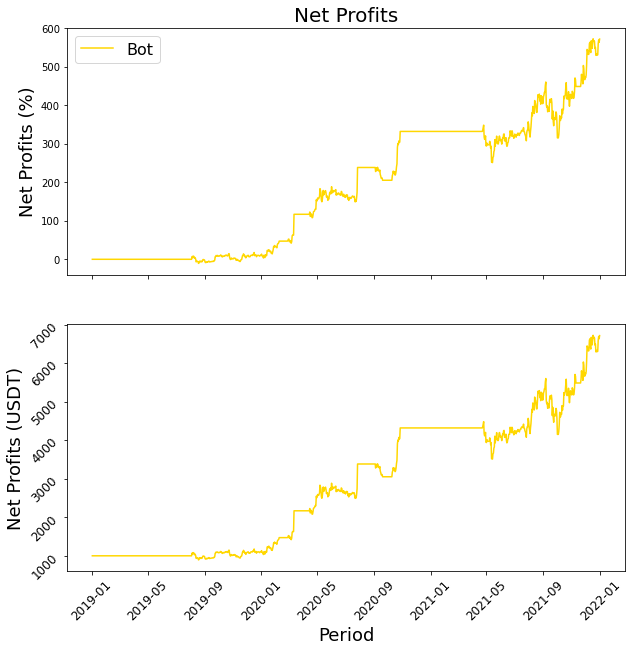

In [42]:
## Profits
show_unrealised = True
show_realised = False
show_hodl = False

profit_bot_realised = ((data['realised_pnl'] - initial_capital)/initial_capital) * 100
profit_bot_unrealised = ((data['unrealised_pnl'] - initial_capital)/initial_capital) * 100
profit_hodl = ((data['hodl'] - data.iloc[0]['hodl'])/data.iloc[0]['hodl']) * 100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
if show_unrealised:
    ax1.plot(data['timestamp'], profit_bot_unrealised, color='gold', label='Bot')
if show_realised:
    ax1.plot(data['timestamp'], profit_bot_realised, color='gold', label='Bot (realised)', ls= '--')
if show_hodl:
    ax1.plot(data['timestamp'], profit_hodl, color='purple', label='Hodl')
ax1.set_title('Net Profits', fontsize=20)
ax1.set_ylabel('Net Profits (%)', fontsize=18)
ax1.set_xticklabels([])
ax1.legend(fontsize=16)
if show_unrealised:
    ax2.plot(data['timestamp'], data['unrealised_pnl'], color='gold', label='Bot')
if show_realised:
    ax2.plot(data['timestamp'], data['realised_pnl'], color='gold', label='Bot (realised)', ls= '--')
if show_hodl:
    ax2.plot(data['timestamp'], data['hodl'], color='purple', label='Hodl')
ax2.set_xlabel('Period', fontsize=18)
ax2.set_ylabel('Net Profits (' + name_quote + ')', fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=12, rotation = 45)

print(f" \n\n      ** Profits ** \n")
print(f" > Period: {data['timestamp'].iloc[0]} -> {data['timestamp'].iloc[-1]} ")
print(f" > Starting balance: {initial_capital} {name_quote}")
print(f" > Final balance Bot: {round(data.iloc[-1]['unrealised_pnl'],2)} {name_quote}")
print(f" > Final balance Hodl: {round(data.iloc[-1]['hodl'],2)} {name_quote}")
print(f" > Bot net profits: {round(profit_bot_unrealised.iloc[-1],2)}%")
print(f" > Hodl net profits: {round(profit_hodl.iloc[-1],2)}%")
print(f" > Net profits ratio Bot / Hodl: {round(data.iloc[-1]['unrealised_pnl']/data.iloc[-1]['hodl'],2)}")


## Trades
orders = pd.json_normalize(orders, sep='_')
n_orders = len(orders.index)
if not ignore_longs:
    n_longs = orders['type'].value_counts()['long entry']
else:
    n_longs = 0
if not ignore_shorts:
    n_shorts = orders['type'].value_counts()['short entry']
else:
    n_shorts = 0
n_entry_orders = 0
if not ignore_longs:
    n_entry_orders += orders['type'].value_counts()['long entry']
if not ignore_shorts:
    n_entry_orders += orders['type'].value_counts()['short entry']

n_exit_orders = 0
if 'long exit' in orders['type'].value_counts():
    n_exit_orders += orders['type'].value_counts()['long exit']
if 'long tp' in orders['type'].value_counts():
    n_exit_orders += orders['type'].value_counts()['long tp']
if 'long sl' in orders['type'].value_counts():
    n_exit_orders += orders['type'].value_counts()['long sl']
if 'short exit' in orders['type'].value_counts():
    n_exit_orders += orders['type'].value_counts()['short exit']
if 'short tp' in orders['type'].value_counts():
    n_exit_orders += orders['type'].value_counts()['short tp']
if 'short sl' in orders['type'].value_counts():
    n_exit_orders += orders['type'].value_counts()['short sl']


orders.loc[::2, 'pnl'] = np.nan
orders['Win'] = ''
orders.loc[orders['pnl']>0,'Win'] = 'Yes'
orders.loc[orders['pnl']<=0,'Win'] = 'No'
if 'Yes' in orders['Win'].value_counts():
    n_pos_trades = orders['Win'].value_counts()['Yes']
else:
    n_pos_trades = 0
if 'No' in orders['Win'].value_counts():
    n_neg_trades = orders['Win'].value_counts()['No']
else:
    n_neg_trades = 0

winrate = round(n_pos_trades / (n_pos_trades+n_neg_trades) * 100,2)
orders['pnl%'] = orders['pnl'] / (orders['wallet'] - orders['pnl'])  * 100
avg_trades = round(orders['pnl%'].mean(),2)
avg_pos_trades = round(orders.loc[orders['Win'] == 'Yes']['pnl%'].mean(),2)
avg_neg_trades = round(orders.loc[orders['Win'] == 'No']['pnl%'].mean(),2)
best_trade = orders['pnl%'].max()
when_best_trade = orders['timestamp'][orders.loc[orders['pnl%'] == best_trade].index.tolist()[0]]
best_trade = round(best_trade,2)
worst_trade = orders['pnl%'].min()
when_worst_trade = orders['timestamp'][orders.loc[orders['pnl%'] == worst_trade].index.tolist()[0]]
worst_trade = round(worst_trade,2)

print(f" \n      ** Trades ** \n")
print(f" > Orders: {n_orders} ({n_entry_orders} buys, {n_exit_orders} sells)")
print(f" > Number of closed trades: {n_pos_trades+n_neg_trades}")
print(f" > Winrate: {winrate}%")
print(f" > Average trade profits: {avg_trades}%")
print(f" > Number of winning trades: {n_pos_trades}")
print(f" > Number of losing trades: {n_neg_trades}")
print(f" > Average winning trades: {avg_pos_trades}%")
print(f" > Average losing trades: {avg_neg_trades}%")
print(f" > Best trade: {best_trade}% on the {when_best_trade}")
print(f" > Worst trade: {worst_trade}% on the {when_worst_trade}")


## Health
worst_drawdown = round(data['drawdown'].min()*100,2)
avg_drawdown = round(data['drawdown'].mean()*100,2)
daily_returns = data['unrealised_pnl'].pct_change()
daily_returns = daily_returns.dropna()
sharpe_ratio = round(np.sqrt(252) * daily_returns.mean() / daily_returns.std(),2)

print(f" \n      ** Health ** \n")
print(f" > Maximum drawdown: {worst_drawdown}%")
print(f" > Annualized Sharpe ratio: {sharpe_ratio}")


## fees
total_fee = round(orders['fee'].sum(),2)
biggest_fee = round(orders['fee'].max(),2)
avg_fee = round(orders['fee'].mean(),2)

print(f" \n      ** Fees ** \n")
print(f" > Total: {total_fee} {name_quote}")
print(f" > Biggest: {biggest_fee} {name_quote}")
print(f" > Average: {avg_fee} {name_quote} \n")